# Assignment

In [1]:
# Import 

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4
np.random.seed(233)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 3 0 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]]
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 1 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 1 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [3 0 0 0]
 [0 0 1 2]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[0 0 0 0]
 [0 3 0 0]
 [0 0 0 2]
 [0 0 0 1]]
0  0
check?  0
dofk2  3


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.219 Number of steps:  7.217


In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = [0.00005, 0.0005, 0.005, 0.05]      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = [0.95, 0.85, 0.75, 0.65, 0.55, 0.45, 0.35]        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# Exponential Moving Average Parameter
alpha = 0.0001

# SAVING VARIABLES
R_save = np.zeros([len(beta), len(gamma), N_episodes])
N_moves_save = np.zeros([len(beta), len(gamma), N_episodes])
wins_save = np.zeros([len(beta), len(gamma), N_episodes])
max_R_save = np.zeros([len(beta), len(gamma)])
min_N_moves_save = np.zeros([len(beta), len(gamma)])
proportion_wins_save = np.zeros([len(beta), len(gamma)])

In [6]:
def Initialize():
    # weights
    global W1, W2, bias_W1, bias_W2
    W1=np.random.uniform(0,1,(N_h,N_in))
    W1=np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
    W2=np.random.uniform(0,1,(N_a,N_h))
    W2=np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))
    # bias
    bias_W1=np.zeros((N_h,))
    bias_W2=np.zeros((N_a,))

In [7]:
def Q_values(X, W1, W2, bias_W1, bias_W2):
    # Neural activation: input layer -> hidden layer
    activation1 = np.dot(W1, X) + bias_W1
    #sig
    out1 = 1 / (1 + np.exp(-activation1))
    # Neural activation: hidden layer -> output layer
    activation2 = np.dot(W2, out1) + bias_W2
    #sig
    Q = 1 / (1 + np.exp(-activation2))
    return Q, out1

def EpsilonGreedy_Policy(epsilon,Q,a):
    if np.random.uniform(0,1) < epsilon:
        a_agent= a[np.random.randint(len(a))]
    else:
        allowed_Q=[]
        for act in a:
            allowed_Q.append(Q[act])
        best_index=np.argmax(allowed_Q)
        a_agent=a[best_index]

    return a_agent

In [8]:
# import progress bar
from time import sleep
from tqdm import tqdm

In [9]:
# Training loop
for b_index in range(len(beta)):
    for g_index in range(len(gamma)):
        Initialize()
        # for n in range(N_episodes):
        for n in tqdm(range(N_episodes)):

            epsilon_f = epsilon_0 / (1 + beta[b_index] * n)   ## DECAYING EPSILON
            Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
            i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

            S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

            a,_=np.where(allowed_a==1)
            # Find the Qvalues
            Q, out1 = Q_values(X, W1, W2, bias_W1, bias_W2)
            # Make an action
            a_agent = EpsilonGreedy_Policy(epsilon_f, Q, a)

            while Done==0:                           ## START THE EPISODE

                # Add to number of moves for the game
                N_moves_save[b_index][g_index][n] = N_moves_save[b_index][g_index][n]+1
                
                # Exponential moving average of the number of moves per game
                if n > 0:
                    N_moves_save[b_index][g_index][n] = ((1-alpha) * N_moves_save[b_index][g_index][n-1]) + (alpha*N_moves_save[b_index][g_index][n])

                #return self.Board, X, allowed_a, R, Done    
                S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)

                ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
                if Done==1:
                    if R:
                        wins_save[b_index][g_index][n] = 1

                    # Backpropagation: output layer -> hidden layer
                    delta2 = (R - Q[a_agent]) * np.heaviside(Q[a_agent], 0)
                    W2 += eta * np.outer(delta2, out1)
                    bias_W2 += eta * delta2

                    #Backpropagation: hidden -> input layer
                    delta1 = np.dot(W2[a_agent], delta2) * np.heaviside(out1, 0)
                    W1 += eta * np.outer(delta1,X)
                    bias_W1 += eta * delta1

                    #set the reward for the game
                    R_save[b_index][g_index][n] = R

                    #exponential moving average of the reward R
                    if n > 0:
                        R_save[b_index][g_index][n] = ((1-alpha) * R_save[b_index][g_index][n-1]) + (alpha*R_save[b_index][g_index][n])  
                    else:
                        R_save[b_index][g_index][n] = 0
                    break   

                # IF THE EPISODE IS NOT OVER...
                else:
                    a_next,_ = np.where(allowed_a_next==1)
                    Q_next, out1_next = Q_values(X_next, W1, W2, bias_W1, bias_W2)  
                    a_agent_next = EpsilonGreedy_Policy(epsilon_f, Q_next, a_next) 

                    # Backpropagation: output layer -> hidden layer
                    delta2 = (R + gamma[g_index] * Q_next[a_agent_next] - Q[a_agent]) * np.heaviside(Q[a_agent], 0)
                    W2 += eta * np.outer(delta2, out1)
                    bias_W2 += eta * delta2

                    #Backpropagation: hidden -> input layer
                    delta1 = np.dot(W2[a_agent], delta2) * np.heaviside(out1, 0)
                    W1 += eta * np.outer(delta1,X)
                    bias_W1 += eta * delta1

                # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S = np.copy(S_next)
                X = np.copy(X_next)  
                allowed_a = np.copy(allowed_a_next)
                a_agent = np.copy(a_agent_next)       
                Q = np.copy(Q_next)
                out1 = np.copy(out1_next)

                i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
       
        max_R_save[b_index][g_index] = max(R_save[b_index][g_index])
        min_N_moves_save[b_index][g_index] = min(N_moves_save[b_index][g_index])
        proportion_wins_save[b_index][g_index] = (wins_save[b_index][g_index] == 1).sum()/N_episodes

100%|██████████| 100000/100000 [7:33:50<00:00,  3.67it/s]   


In [10]:
print(max_R_save)
print(min_N_moves_save)
print(proportion_wins_save)

[[0.83672803 0.74107963 0.74720634 0.65485165 0.45170874 0.63201612
  0.67302816]
 [0.90361602 0.68489562 0.8038562  0.70535072 0.60974227 0.68394248
  0.6033496 ]
 [0.9215124  0.75601508 0.61973781 0.66070218 0.641018   0.59239064
  0.41802734]
 [0.87802675 0.76280606 0.66908245 0.65702104 0.61371312 0.78570091
  0.63283082]]
[[ 5.5436149   3.59757323  1.          6.4900669   4.24940996  4.44010544
   4.64750558]
 [ 3.88555375  1.          5.44162694  3.8684598   2.52431166  5.78527039
   3.04503492]
 [ 6.10916271  4.34196497  5.02199635  2.89430487  3.08266627  1.99980001
   1.        ]
 [ 6.40707002  5.66042382  2.92854048  3.91247978  1.         12.40777399
   3.12535115]]
[[0.73796 0.61156 0.58711 0.58202 0.36175 0.51212 0.55539]
 [0.82668 0.59463 0.71325 0.60948 0.51492 0.58442 0.47353]
 [0.79804 0.65449 0.51412 0.5556  0.52223 0.4905  0.35863]
 [0.75817 0.70083 0.59902 0.60372 0.56845 0.62778 0.53633]]


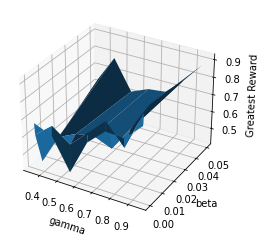

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize 3d figure
fig = plt.figure()
ax = plt.axes(projection='3d')

# create meshgrid
gammas, betas = np.meshgrid(gamma, beta)

# plot
ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('Greatest Reward')
ax.plot_surface(gammas, betas, max_R_save)

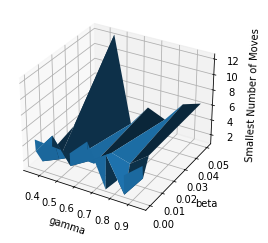

In [12]:
# Initialize 3d figure
fig = plt.figure()
ax = plt.axes(projection='3d')

# create meshgrid
gammas, betas = np.meshgrid(gamma, beta)

# plot
ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('Smallest Number of Moves')
ax.plot_surface(gammas, betas, min_N_moves_save)

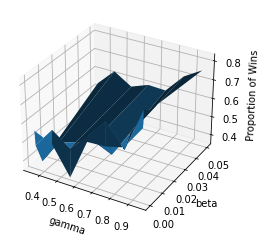

In [13]:
# Initialize 3d figure
fig = plt.figure()
ax = plt.axes(projection='3d')

# create meshgrid
gammas, betas = np.meshgrid(gamma, beta)

# plot
ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('Proportion of Wins')
ax.plot_surface(gammas, betas, proportion_wins_save)

In [14]:
# Parameters that produced the greatest rewards are potential optimal parameters
best_beta_candidates = np.argmax(max_R_save, axis=0)
best_gamma_candidates = np.argmax(max_R_save, axis=1)

min_moves = 200
best_b_index = 0
best_g_index = 0

# Choose parameters that are within the list of candidates and are associated with minimal number of moves
for i in range(len(min_N_moves_save)):
    for j in range(len(min_N_moves_save[i])):
        if min_N_moves_save[i][j] < min_moves and i in best_beta_candidates and j in best_gamma_candidates:
            min_moves = min_N_moves_save[i][j]
            best_b_index = i
            best_g_index = j
            
best_beta = beta[best_b_index]
best_gamma = gamma[best_g_index] 

print(best_beta, best_gamma)

0.0005 0.95


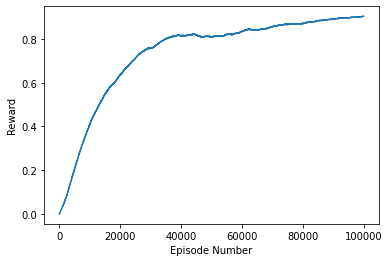

In [15]:
# Exponential moving average of reward per game over time using optimal beta and gamma
plt.plot(R_save[best_b_index][best_g_index])
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()

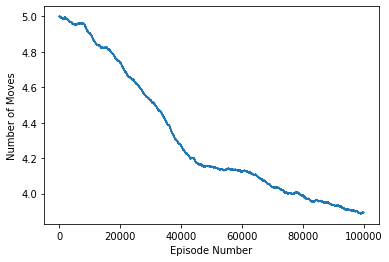

In [16]:
# Exponential moving average of number of moves per game over time using optimal beta and gamma
plt.plot(N_moves_save[best_b_index][best_g_index])
plt.xlabel('Episode Number')
plt.ylabel('Number of Moves')
plt.show()